In [1]:
import random, numpy as np, pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
alphap = 2
probp = 0.75
expon = 2 * alphap - 1

In [2]:
def betadist(alpha):
    """gives a random number from beta distribution"""
    return random.betavariate(alpha,alpha)

In [3]:
def decision(probability):
    """
    decides with a given probability whether to keep the right part
    """
    if float(probability) > random.random():
        return True
    else: 
        return False

In [4]:
def splitting(segment):
    """
    splits a given segment. left and right are endpoints of the segment
    returns : 
        xL -> length of the left segment
        xR -> length of the right segment
        flag -> keeping the right segment
        xLp, xRp -> probability(unnormalized) for being selected
        change -> change of normalization const
    """
    xL = segment * betadist(alphap)
    xR = segment - xL
    flag = decision(probp)
    xLp = xL**expon
    xRp = xR**expon
    change = xLp + xRp - segment**expon
    return xL, xR, flag, xLp, xRp, change

In [5]:
def pickindex(frag_prob, frac_sum):
    """
    picks up a segment to be subsequently split
    """
    r = random.uniform(0,1)
    
    if r <= frac_sum:
        sum_ = 0
        for index in range(len(frag_prob)):
            sum_ += frag_prob[index]
            if sum_ < r:
                continue
            else:
                return index

In [6]:
def number_length(segment_lengths,flags):
    
    N = 0
    M = 0

    for i in range(len(flags)):
        if flags[i]:
            N += 1
            M += segment_lengths[i]
            pass
        pass
    return N, M

In [7]:
def bin_maker(max_value, bin_number):
    bin_size = max_value/bin_number
    bins = [0.]
    for i in range(bin_number):
        bin_edge = (i+1)*bin_size
        bins.append(bin_edge)
        pass
    return bins

In [8]:
def realization_value(total_iteration):
    
    lengths = [1.]
    flags = [True]
    frag_prob = [1.] # raw probability, not normalized
    #frag_prob_sum = 1.0 # normalization const
    frac_sum = 1.0
    
    for i in range(total_iteration + 1):
        
        #index = pickindex(frag_prob, frag_prob_sum)
        index = pickindex(frag_prob, frac_sum)
        
        if index != None and flags[index] == True:

            xL, xR, flag, xLp, xRp, change = splitting(lengths[index])
            
            lengths[index] = xL
            lengths.append(xR)
            flags.append(flag)
            frag_prob[index] = xLp 
            frag_prob.append(xRp)
            #frag_prob_sum += change
            frac_sum += change
            pass
        
    lengths = np.array(lengths)
    true_lengths = lengths[flags]
    #log_lengths = np.log(true_lengths) * -1

    #return log_lengths
    return true_lengths

In [9]:
def ensembling(total_iteration, ensemble_size):

    C_ensemble = np.array([])
    
    for i in range(ensemble_size):
        true_lengths = realization_value(total_iteration)
        C_ensemble = np.append(C_ensemble, true_lengths)
        pass
    
    return C_ensemble

In [10]:
def np_histrogram(data, bin_size = 0.001):
    bin_number = int((np.max(data) - np.min(data))//bin_size) + 1
    y, x = np.histogram(data, bins = bin_number)
    return plt.plot(x[1:], y)

In [11]:
ens1 = ensembling(10_000, 10_000)
ens2 = ensembling(20_000, 10_000)
ens3 = ensembling(30_000, 10_000)

In [12]:
ens1p = np.array(ens1)
ens2p = np.array(ens2)
ens3p = np.array(ens3)

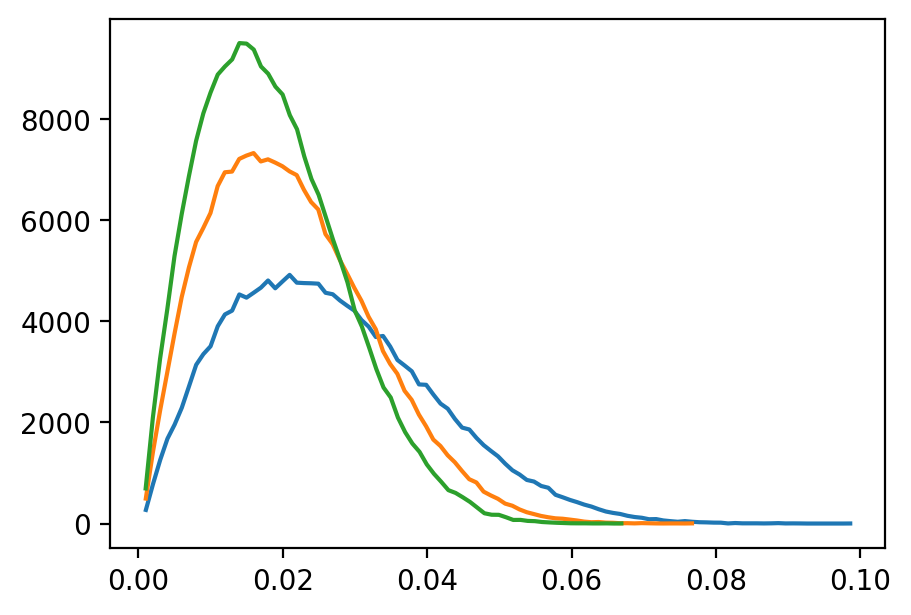

In [14]:
fig, axes = plt.subplots(1,1,figsize = (5,3.5),dpi = 200)
np_histrogram(ens1p)
np_histrogram(ens2p)
np_histrogram(ens3p)
lines = axes.get_lines()
data0_hist = lines[0].get_data()
data1_hist = lines[1].get_data()
data2_hist = lines[2].get_data()

In [15]:
ens1_log = np.log(ens1p) * -1
ens2_log = np.log(ens2p) * -1
ens3_log = np.log(ens3p) * -1

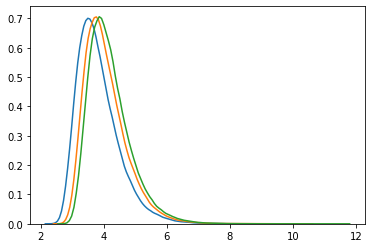

In [16]:
sns.kdeplot(ens1_log)
sns.kdeplot(ens2_log)
sns.kdeplot(ens3_log)

In [17]:
def log_rescaled(input_array, total_iteration):
    shift = np.log(total_iteration)/expon
    outout_array = input_array - shift
    return np.asarray(outout_array)

In [18]:
ens1_log_p = log_rescaled(ens1_log, 10_000)
ens2_log_p = log_rescaled(ens2_log, 20_000)
ens3_log_p = log_rescaled(ens3_log, 30_000)

In [19]:
import scipy.special as sc

def logdist2(u_list):
    df = 0.778719
    c2 = -(sc.gamma(1/3)/sc.gamma(5/3))*(sc.gamma((df+5)/3)/sc.gamma((df+3)/3))
    density1 = -3*(df+2)*np.exp(-3*u_list)*sc.hyp1f1(-(df-1)/3, 4/3, -np.exp(-3*u_list))
    density2 = -(3/5)*c2*df*np.exp(-5*u_list)*sc.hyp1f1(-(df-3)/3, 8/3, -np.exp(-3*u_list))
    density3 = -2*c2*np.exp(-2*u_list)*sc.hyp1f1(-df/3, 5/3, -np.exp(-3*u_list))
    density = density1 + density2+ density3
    return density

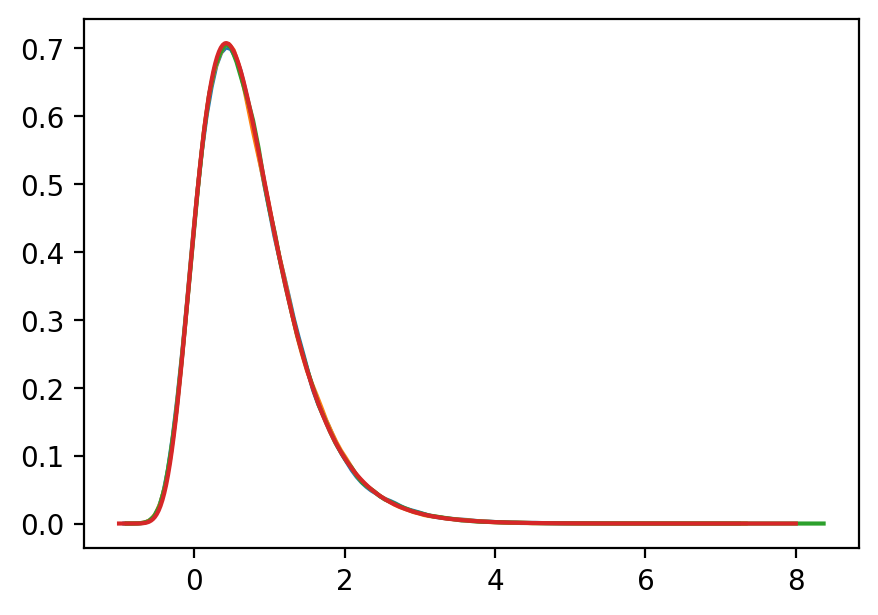

In [20]:
fig, axes = plt.subplots(1,1,figsize = (5,3.5),dpi = 200)
sns.kdeplot(ens1_log_p,ax=axes)
sns.kdeplot(ens2_log_p,ax=axes)
sns.kdeplot(ens3_log_p,ax=axes)
u_list = np.linspace(-1,8,360)
axes.plot(u_list, logdist2(u_list))
lines = axes.get_lines()
data0 = lines[0].get_data()
data1 = lines[1].get_data()
data2 = lines[2].get_data()

In [21]:
np.savetxt('2_data_coll_10k', np.c_[data0[0],data0[1]])
np.savetxt('2_data_coll_20k', np.c_[data1[0],data1[1]])
np.savetxt('2_data_coll_30k', np.c_[data2[0],data2[1]])

In [22]:
np.savetxt('2_hist_10k', np.c_[data0_hist[0],data0_hist[1]])
np.savetxt('2_hist_20k', np.c_[data1_hist[0],data1_hist[1]])
np.savetxt('2_hist_30k', np.c_[data2_hist[0],data2_hist[1]])